In [1]:
# mount drive (optional but recommended to save models/dataset)
#from google.colab import drive
#drive.mount('/content/drive')

# install dependencies
!pip install -q ultralytics pycocotools opencv-python-headless matplotlib wget


  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 26.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 134.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 106.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 59.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.7/188.7 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 125.3 MB/s eta 0:00:00


In [2]:
from google.colab import files
uploaded = files.upload()


Saving taco.zip to taco.zip


In [3]:
!unzip taco.zip -d taco


Archive:  taco.zip
  inflating: taco/README.dataset.txt  
  inflating: taco/README.roboflow.txt  
  inflating: taco/data.yaml          
   creating: taco/test/
   creating: taco/test/images/
 extracting: taco/test/images/1000_jpg.rf.e8071ded90387e203841a04b268153ad.jpg  
 extracting: taco/test/images/1001_jpg.rf.fd8bd7d3fb28999bcc4e5ed3efa6c0b1.jpg  
 extracting: taco/test/images/1017_jpg.rf.b438e7cee9eef4b38c99914a6c774ed9.jpg  
 extracting: taco/test/images/101_jpg.rf.0f683dd32fd8d68d75c5649fc3dadefa.jpg  
 extracting: taco/test/images/1027_jpg.rf.a76596c583d0c269d45ea6dbabb2212c.jpg  
 extracting: taco/test/images/1030_jpg.rf.3f51ccd30c6e23fcc3e1bdd0dd77b199.jpg  
 extracting: taco/test/images/1036_jpg.rf.998fa68994b398dce6474efabf02b471.jpg  
 extracting: taco/test/images/1038_jpg.rf.3f1649dce771a85a153464f76c221b4f.jpg  
 extracting: taco/test/images/1039_jpg.rf.2b97779e4fb254cbc46e0ce26e7007ab.jpg  
 extracting: taco/test/images/1086_jpg.rf.e5a97e5b1ed42b8dc5751b68160baf32.jpg  


In [4]:
!pip install ultralytics


In [5]:
!cat taco/data.yaml


train: ../train/images
val: ../valid/images
test: ../test/images

nc: 59
names: ['Aerosol', 'Aluminium blister pack', 'Battery', 'Broken glass', 'Carded blister pack', 'Cigarette', 'Clear plastic bottle', 'Corrugated carton', 'Crisp packet', 'Disposable food container', 'Disposable plastic cup', 'Drink can', 'Drink carton', 'Egg carton', 'Foam cup', 'Foam food container', 'Food Can', 'Food waste', 'Garbage bag', 'Glass bottle', 'Glass cup', 'Glass jar', 'Magazine paper', 'Meal carton', 'Metal bottle cap', 'Metal lid', 'Normal paper', 'Other carton', 'Other plastic', 'Other plastic bottle', 'Other plastic container', 'Other plastic cup', 'Other plastic wrapper', 'Paper bag', 'Paper cup', 'Paper straw', 'Pizza box', 'Plastic bottle cap', 'Plastic film', 'Plastic glooves', 'Plastic lid', 'Plastic straw', 'Plastic utensils', 'Polypropylene bag', 'Pop tab', 'Rope - strings', 'Scrap metal', 'Shoe', 'Single-use carrier bag', 'Six pack rings', 'Spread tub', 'Squeezable tube', 'Styrofoam piece'

In [11]:
import os, json, shutil, random, math
from pathlib import Path
random.seed(42)

# PATHS - update if different
TACO_DIR = Path('/content/taco')          # <-- where the unzipped dataset is located
ANNOTATION_FILE = TACO_DIR / 'data.yaml'  # adjust if different
OUT_DIR = Path('/content/taco_yolo')      # output root

OUT_DIR.mkdir(parents=True, exist_ok=True)


# load data.yaml
if not ANNOTATION_FILE.exists():
    raise FileNotFoundError(f"Can't find {ANNOTATION_FILE}. Make sure you uploaded and unzipped taco.zip correctly.")

import yaml
with open(ANNOTATION_FILE,'r') as f:
    data_config = yaml.safe_load(f)

class_names = data_config['names']
nc = data_config['nc']

# Construct absolute paths for the original data directories
train_source_dir = TACO_DIR / Path(data_config['train']).parent # Get the parent directory of the relative path
val_source_dir = TACO_DIR / Path(data_config['val']).parent
test_source_dir = TACO_DIR / Path(data_config['test']).parent if 'test' in data_config else None


# copy images and labels to the output directory
for split_name, source_dir in [('train', train_source_dir), ('val', val_source_dir), ('test', test_source_dir)]:
    if source_dir and source_dir.exists():
        imgs_dir_out = OUT_DIR / split_name / 'images'
        lbls_dir_out = OUT_DIR / split_name / 'labels'
        imgs_dir_out.mkdir(parents=True, exist_ok=True)
        lbls_dir_out.mkdir(parents=True, exist_ok=True)

        # Copy images
        source_img_dir = source_dir / 'images'
        if source_img_dir.exists():
            for img_path in source_img_dir.glob('*.jpg'): # Assuming images are jpg
                shutil.copy(img_path, imgs_dir_out / img_path.name)
        else:
            print(f"Warning: Image directory not found for {split_name} split: {source_img_dir}")


        # Copy labels
        source_label_dir = source_dir / 'labels'
        if source_label_dir.exists():
             for label_path in source_label_dir.glob('*.txt'):
                shutil.copy(label_path, lbls_dir_out / label_path.name)
        else:
             print(f"Warning: Label directory not found for {split_name} split: {source_label_dir}")
             # Create empty label files for images without labels if needed (optional, depends on dataset)
             # for img_path in imgs_dir_out.glob('*.jpg'):
             #     empty_label_path = lbls_dir_out / (img_path.stem + '.txt')
             #     if not empty_label_path.exists():
             #         open(empty_label_path, 'w').close()


# write data.yaml for YOLOv8
data_yaml = OUT_DIR / 'data.yaml'
content = {
    'names': class_names,
    'nc': nc,
    'train': str(OUT_DIR / 'train' / 'images'),
    'val': str(OUT_DIR / 'val' / 'images')
}
if test_source_dir:
    content['test'] = str(OUT_DIR / 'test' / 'images')

import yaml
with open(data_yaml,'w') as f:
    yaml.dump(content, f)
print("Done. YOLO dataset at:", OUT_DIR)
print("Data yaml:", data_yaml)

Done. YOLO dataset at: /content/taco_yolo
Data yaml: /content/taco_yolo/data.yaml


In [12]:
!pip install ultralytics


In [13]:
!ls /content/taco_yolo/train/images | head -n 5
!cat /content/taco_yolo/data.yaml


names:
- Aerosol
- Aluminium blister pack
- Battery
- Broken glass
- Carded blister pack
- Cigarette
- Clear plastic bottle
- Corrugated carton
- Crisp packet
- Disposable food container
- Disposable plastic cup
- Drink can
- Drink carton
- Egg carton
- Foam cup
- Foam food container
- Food Can
- Food waste
- Garbage bag
- Glass bottle
- Glass cup
- Glass jar
- Magazine paper
- Meal carton
- Metal bottle cap
- Metal lid
- Normal paper
- Other carton
- Other plastic
- Other plastic bottle
- Other plastic container
- Other plastic cup
- Other plastic wrapper
- Paper bag
- Paper cup
- Paper straw
- Pizza box
- Plastic bottle cap
- Plastic film
- Plastic glooves
- Plastic lid
- Plastic straw
- Plastic utensils
- Polypropylene bag
- Pop tab
- Rope - strings
- Scrap metal
- Shoe
- Single-use carrier bag
- Six pack rings
- Spread tub
- Squeezable tube
- Styrofoam piece
- Tissues
- Toilet tube
- Tupperware
- Unlabeled litter
- Wrapping paper
- json
nc: 59
test: /content/taco_yolo/test/images
t

In [16]:
import os, shutil
from pathlib import Path
import zipfile

# === Step 1: Paths ===
ZIP_PATH = "/content/taco.zip"   # Change if your uploaded ZIP is different
OUT_DIR = Path("/content/taco_yolo")

# Clean old output if exists
if OUT_DIR.exists():
    shutil.rmtree(OUT_DIR)
OUT_DIR.mkdir(parents=True, exist_ok=True)

# === Step 2: Unzip ===
with zipfile.ZipFile(ZIP_PATH, 'r') as zip_ref:
    zip_ref.extractall("/content/TACO_raw")
print("✅ Unzipped TACO dataset")

# === Step 3: Image extensions ===
IMAGE_EXTS = ['.jpg', '.jpeg', '.png', '.bmp', '.tif', '.tiff']

# === Step 4: Copy images + labels ===
def copy_images_and_labels(source_dir, split_name, out_dir):
    imgs_dir_out = out_dir / split_name / 'images'
    lbls_dir_out = out_dir / split_name / 'labels'
    imgs_dir_out.mkdir(parents=True, exist_ok=True)
    lbls_dir_out.mkdir(parents=True, exist_ok=True)

    # Copy images
    source_img_dir = source_dir / 'images'
    if source_img_dir.exists():
        copied_count = 0
        for img_path in source_img_dir.iterdir():
            if img_path.suffix.lower() in IMAGE_EXTS:
                shutil.copy(img_path, imgs_dir_out / img_path.name)
                copied_count += 1
        print(f"✅ Copied {copied_count} images to {split_name}/images")
    else:
        print(f"⚠️ No image dir found for {split_name}")

    # Copy labels
    source_label_dir = source_dir / 'labels'
    if source_label_dir.exists():
        label_count = 0
        for label_path in source_label_dir.glob('*.txt'):
            shutil.copy(label_path, lbls_dir_out / label_path.name)
            label_count += 1
        print(f"✅ Copied {label_count} labels to {split_name}/labels")
    else:
        print(f"⚠️ No label dir found for {split_name}")

# === Step 5: Detect splits ===
raw_dir = Path("/content/TACO_raw")
splits = ['train', 'val', 'test']

for split in splits:
    split_dir = raw_dir / split
    if split_dir.exists():
        copy_images_and_labels(split_dir, split, OUT_DIR)
    else:
        print(f"⚠️ Split folder '{split}' not found, skipping")

# === Step 6: Check files ===
for split in splits:
    img_count = len(list((OUT_DIR / split / 'images').glob('*.*')))
    lbl_count = len(list((OUT_DIR / split / 'labels').glob('*.txt')))
    print(f"📊 {split}: {img_count} images, {lbl_count} labels")

# === Step 7: Auto-create data.yaml ===
classes = [
    "Aluminium foil",
    "Battery",
    "Blister pack",
    "Bottle",
    "Bottle cap",
    "Broken glass",
    "Can",
    "Carton",
    "Cup",
    "Food waste",
    "Glass jar",
    "Lid",
    "Other plastic",
    "Paper",
    "Paper bag",
    "Plastic bag & wrapper",
    "Plastic container",
    "Plastic gloove",
    "Plastic straw",
    "Pop tab",
    "Rope & strings",
    "Scrap metal",
    "Shoe",
    "Squeezable tube",
    "Styrofoam piece",
    "Unlabeled litter"
]

yaml_path = OUT_DIR / "data.yaml"
with open(yaml_path, "w") as f:
    f.write(f"path: {OUT_DIR}\n")
    f.write(f"train: train/images\n")
    f.write(f"val: val/images\n")
    if (OUT_DIR / "test").exists():
        f.write(f"test: test/images\n")
    f.write("\n")
    f.write(f"names:\n")
    for i, cls in enumerate(classes):
        f.write(f"  {i}: {cls}\n")

print(f"📄 data.yaml created at: {yaml_path}")
print("🎯 Dataset fully ready for YOLOv8 training!")

# Example training command:
print("\nRun this next:")
print(f"!yolo task=detect mode=train model=yolov8n.pt data={yaml_path} epochs=50 imgsz=640")


✅ Unzipped TACO dataset
✅ Copied 1000 images to train/images
✅ Copied 1000 labels to train/labels
⚠️ Split folder 'val' not found, skipping
✅ Copied 100 images to test/images
✅ Copied 100 labels to test/labels
📊 train: 1000 images, 1000 labels
📊 val: 0 images, 0 labels
📊 test: 100 images, 100 labels
📄 data.yaml created at: /content/taco_yolo/data.yaml
🎯 Dataset fully ready for YOLOv8 training!

Run this next:
!yolo task=detect mode=train model=yolov8n.pt data=/content/taco_yolo/data.yaml epochs=50 imgsz=640


In [22]:
!yolo task=detect mode=train model=yolov8n.pt data=/content/taco_yolo/data.yaml epochs=50 imgsz=640

Ultralytics 8.3.177 🚀 Python-3.11.13 torch-2.6.0+cu124 CPU (AMD EPYC 7B12)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/taco_yolo/data.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train6, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.0, pretrained=True, p

In [18]:
!ls -R /content


Streaming output truncated to the last 5000 lines.
1035_jpg.rf.33b638764e54e2b30dd50afa3ed9e493.jpg
1037_jpg.rf.a27e732ae95ce34bddbcb9b7a2f0e10c.jpg
1041_jpg.rf.fda90a034974b5a1225bdc551a7225ce.jpg
1042_jpg.rf.279d5aa56f10f350c50b35675c70559a.jpg
1045_jpg.rf.6cc9ffc86c01a20cb7ad8ebe6ce47a18.jpg
1046_jpg.rf.6dfaeb53f715bb5586d07ae91f77dbeb.jpg
1047_jpg.rf.2bf9ba4be736140afcee1309ce91a97d.jpg
1048_jpg.rf.9ec1d1373b7f6c4c75eb1c2d3254c1f5.jpg
1049_jpg.rf.f255f39424cd8230dceea68677eb0381.jpg
104_jpg.rf.02f6b44d6ac2b70956f1142711eea8da.jpg
1052_jpg.rf.e8d7105337c2ac1558f704cc1a9636ad.jpg
1053_jpg.rf.4109ecc5795c18141f21de56f76a7851.jpg
1054_jpg.rf.5b0b63957de0a590f7a0d4aa5ac3cb5e.jpg
1057_jpg.rf.1c26f6c98f288c0dd15ce0aaefefa7b9.jpg
1058_jpg.rf.1b39b6c4fa091fb6330c3c230a8b5152.jpg
1059_jpg.rf.740bc6b53b80905f7362056bc70c3db6.jpg
105_jpg.rf.c06c6efed098a575df0f0c85bee03172.jpg
1060_jpg.rf.87ea6aa129c64df7128712a786400007.jpg
1062_jpg.rf.b7f2b7344220af15d3e14c0f659c8eda.jpg
1064_jpg.rf.65e8e20f

In [19]:
!ls -R /content/taco_yolo


/content/taco_yolo:
data.yaml  test  train

/content/taco_yolo/test:
images	labels

/content/taco_yolo/test/images:
1000_jpg.rf.e8071ded90387e203841a04b268153ad.jpg
1001_jpg.rf.fd8bd7d3fb28999bcc4e5ed3efa6c0b1.jpg
1017_jpg.rf.b438e7cee9eef4b38c99914a6c774ed9.jpg
101_jpg.rf.0f683dd32fd8d68d75c5649fc3dadefa.jpg
1027_jpg.rf.a76596c583d0c269d45ea6dbabb2212c.jpg
1030_jpg.rf.3f51ccd30c6e23fcc3e1bdd0dd77b199.jpg
1036_jpg.rf.998fa68994b398dce6474efabf02b471.jpg
1038_jpg.rf.3f1649dce771a85a153464f76c221b4f.jpg
1039_jpg.rf.2b97779e4fb254cbc46e0ce26e7007ab.jpg
1086_jpg.rf.e5a97e5b1ed42b8dc5751b68160baf32.jpg
1143_jpg.rf.c31d0f8d9f02185fa4ea695d501ce256.jpg
1161_jpg.rf.b30094ebe7a39e0f8e8b462ab1c78255.jpg
1168_jpg.rf.2056c5afb981eaec2d4240e062bf30de.jpg
1172_jpg.rf.e568bbb565fce0417c17939a6d6fb450.jpg
1179_jpg.rf.e54aaf8ff4b2f563b007c87aba2bf8e4.jpg
1180_jpg.rf.3d727006309a87a81db5bc14bfbc607e.jpg
1181_jpg.rf.dad0dda3df369219d3cc38307fda9f5b.jpg
1182_jpg.rf.45a8e2af212883dc6fd8806f3ee7573a.jpg
119

In [20]:
!ls /content/taco_yolo


data.yaml  test  train


In [21]:
cat /content/taco_yolo/data.yaml


path: /content/taco_yolo
train: train/images
val: test/images
test: test/images

names:
  0: Aluminium foil
  1: Battery
  2: Blister pack
  3: Bottle
  4: Bottle cap
  5: Broken glass
  6: Can
  7: Carton
  8: Cup
  9: Food waste
  10: Glass jar
  11: Lid
  12: Other plastic
  13: Paper
  14: Paper bag
  15: Plastic bag & wrapper
  16: Plastic container
  17: Plastic gloove
  18: Plastic straw
  19: Pop tab
  20: Rope & strings
  21: Scrap metal
  22: Shoe
  23: Squeezable tube
  24: Styrofoam piece
  25: Unlabeled litter


In [23]:
!ls /content/runs/detect/train6/weights


best.pt  last.pt


In [24]:
!yolo task=detect mode=predict model=/content/runs/detect/train6/weights/best.pt source=/content/taco_yolo/test/images


Ultralytics 8.3.177 🚀 Python-3.11.13 torch-2.6.0+cu124 CPU (AMD EPYC 7B12)
Model summary (fused): 72 layers, 3,010,718 parameters, 0 gradients, 8.1 GFLOPs

image 1/100 /content/taco_yolo/test/images/1000_jpg.rf.e8071ded90387e203841a04b268153ad.jpg: 640x640 1 Can, 275.2ms
image 2/100 /content/taco_yolo/test/images/1001_jpg.rf.fd8bd7d3fb28999bcc4e5ed3efa6c0b1.jpg: 640x640 (no detections), 211.4ms
image 3/100 /content/taco_yolo/test/images/1017_jpg.rf.b438e7cee9eef4b38c99914a6c774ed9.jpg: 640x640 1 Cup, 1 Food waste, 218.0ms
image 4/100 /content/taco_yolo/test/images/101_jpg.rf.0f683dd32fd8d68d75c5649fc3dadefa.jpg: 640x640 3 Cartons, 1 Cup, 2 Lids, 1 Pop tab, 1 Styrofoam piece, 180.3ms
image 5/100 /content/taco_yolo/test/images/1027_jpg.rf.a76596c583d0c269d45ea6dbabb2212c.jpg: 640x640 (no detections), 188.4ms
image 6/100 /content/taco_yolo/test/images/1030_jpg.rf.3f51ccd30c6e23fcc3e1bdd0dd77b199.jpg: 640x640 2 Lids, 218.6ms
image 7/100 /content/taco_yolo/test/images/1036_jpg.rf.998fa68994

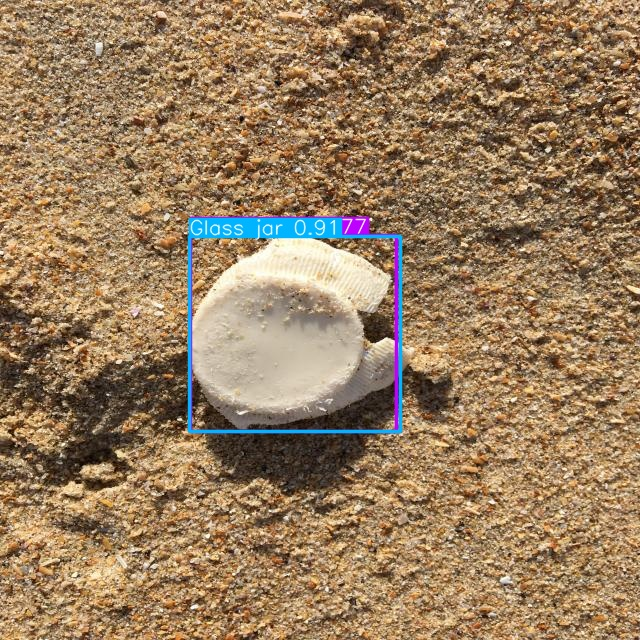

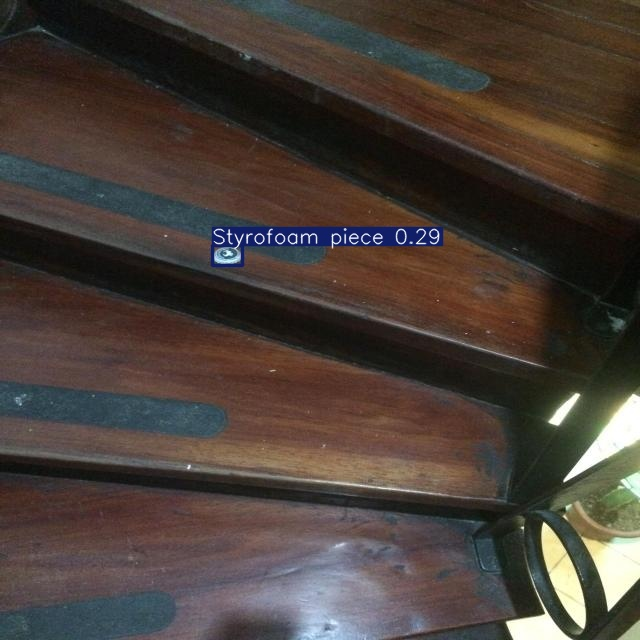

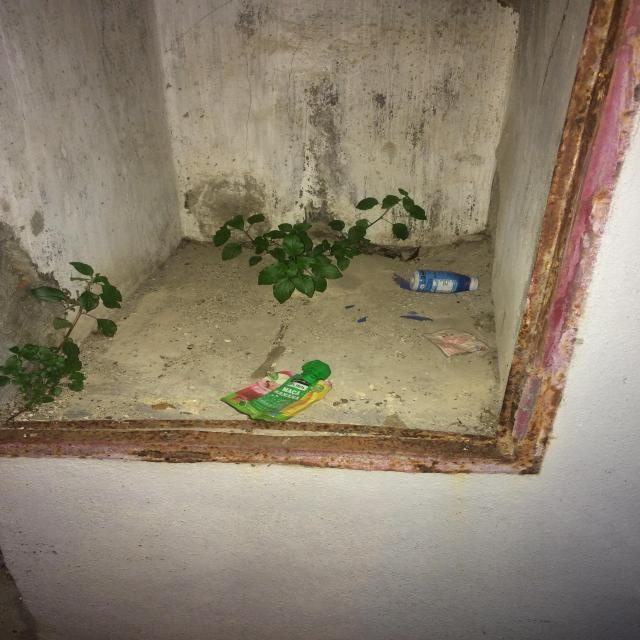

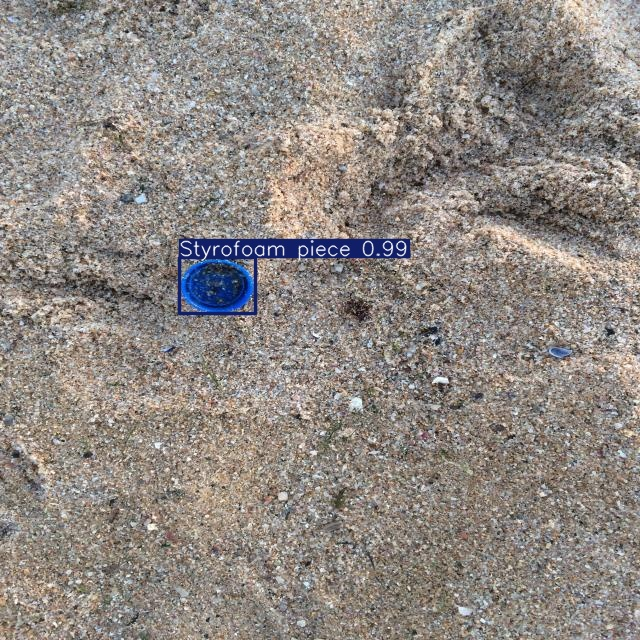

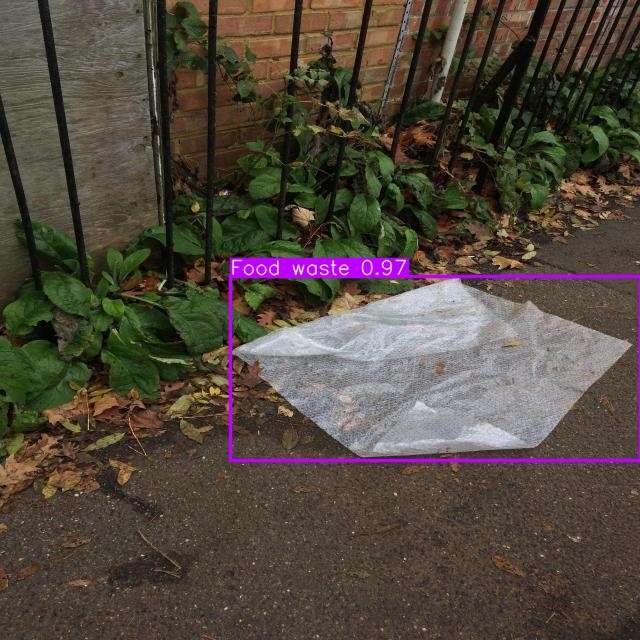

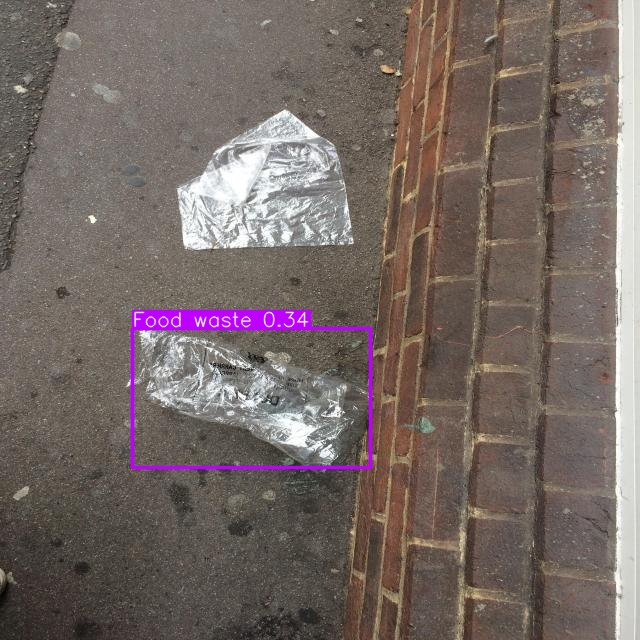

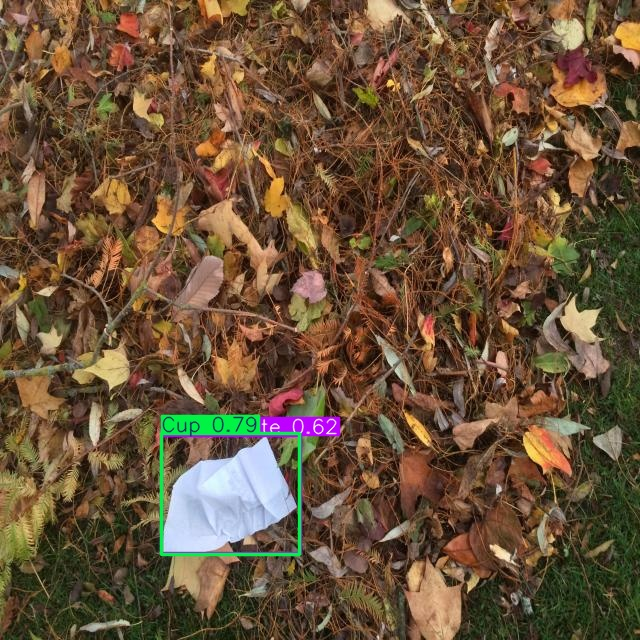

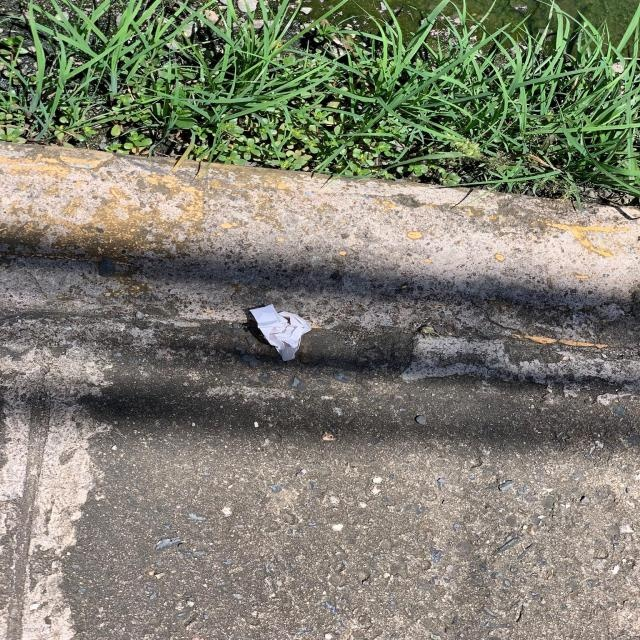

In [29]:
from IPython.display import Image, display
import glob

# Get first 5 predicted images
pred_imgs = glob.glob('/content/runs/detect/predict/*.jpg')

for img_path in pred_imgs[7:15]:
    display(Image(filename=img_path))


In [30]:
!yolo task=detect mode=val model=/content/runs/detect/train6/weights/best.pt data=/content/taco_yolo/data.yaml


Ultralytics 8.3.177 🚀 Python-3.11.13 torch-2.6.0+cu124 CPU (AMD EPYC 7B12)
Model summary (fused): 72 layers, 3,010,718 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2514.8±438.5 MB/s, size: 121.0 KB)
val: Scanning /content/taco_yolo/test/labels.cache... 100 images, 0 backgrounds, 87 corrupt: 100% 100/100 [00:00<?, ?it/s]
val: /content/taco_yolo/test/images/1017_jpg.rf.b438e7cee9eef4b38c99914a6c774ed9.jpg: ignoring corrupt image/label: Label class 26 exceeds dataset class count 26. Possible class labels are 0-25
val: /content/taco_yolo/test/images/101_jpg.rf.0f683dd32fd8d68d75c5649fc3dadefa.jpg: ignoring corrupt image/label: Label class 27 exceeds dataset class count 26. Possible class labels are 0-25
val: /content/taco_yolo/test/images/1027_jpg.rf.a76596c583d0c269d45ea6dbabb2212c.jpg: ignoring corrupt image/label: Label class 41 exceeds dataset class count 26. Possible class labels are 0-25
val: /content/taco_yolo/test/images/1030_jpg.rf.3f51ccd3

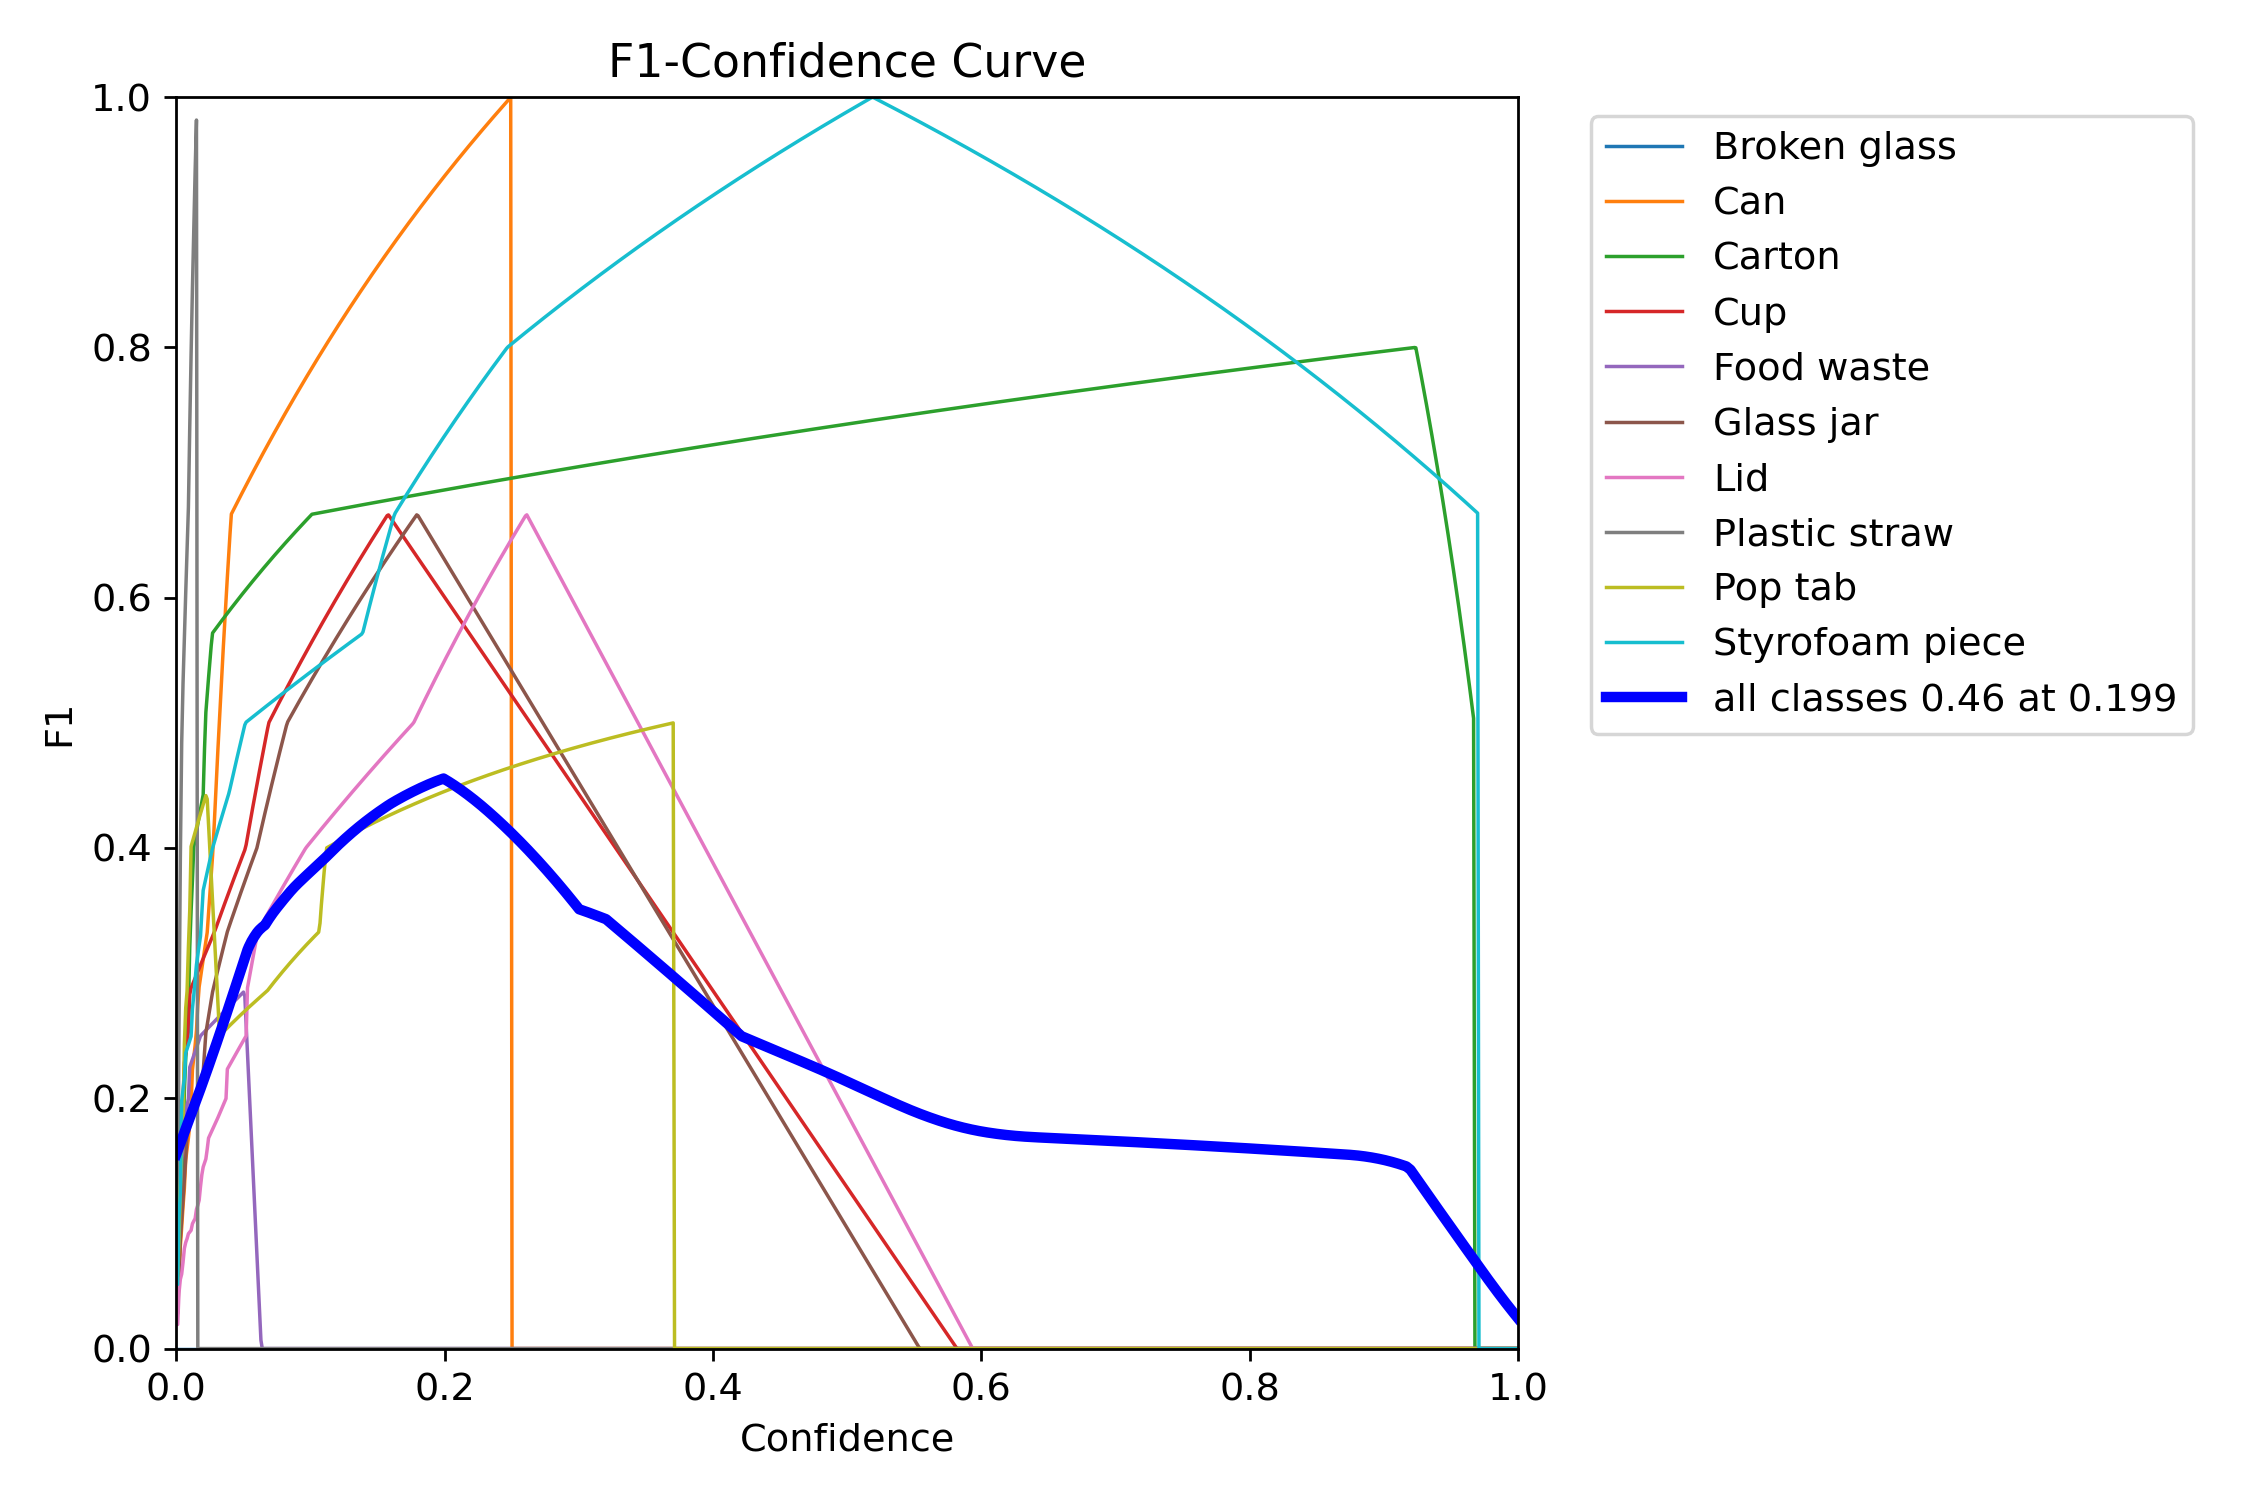

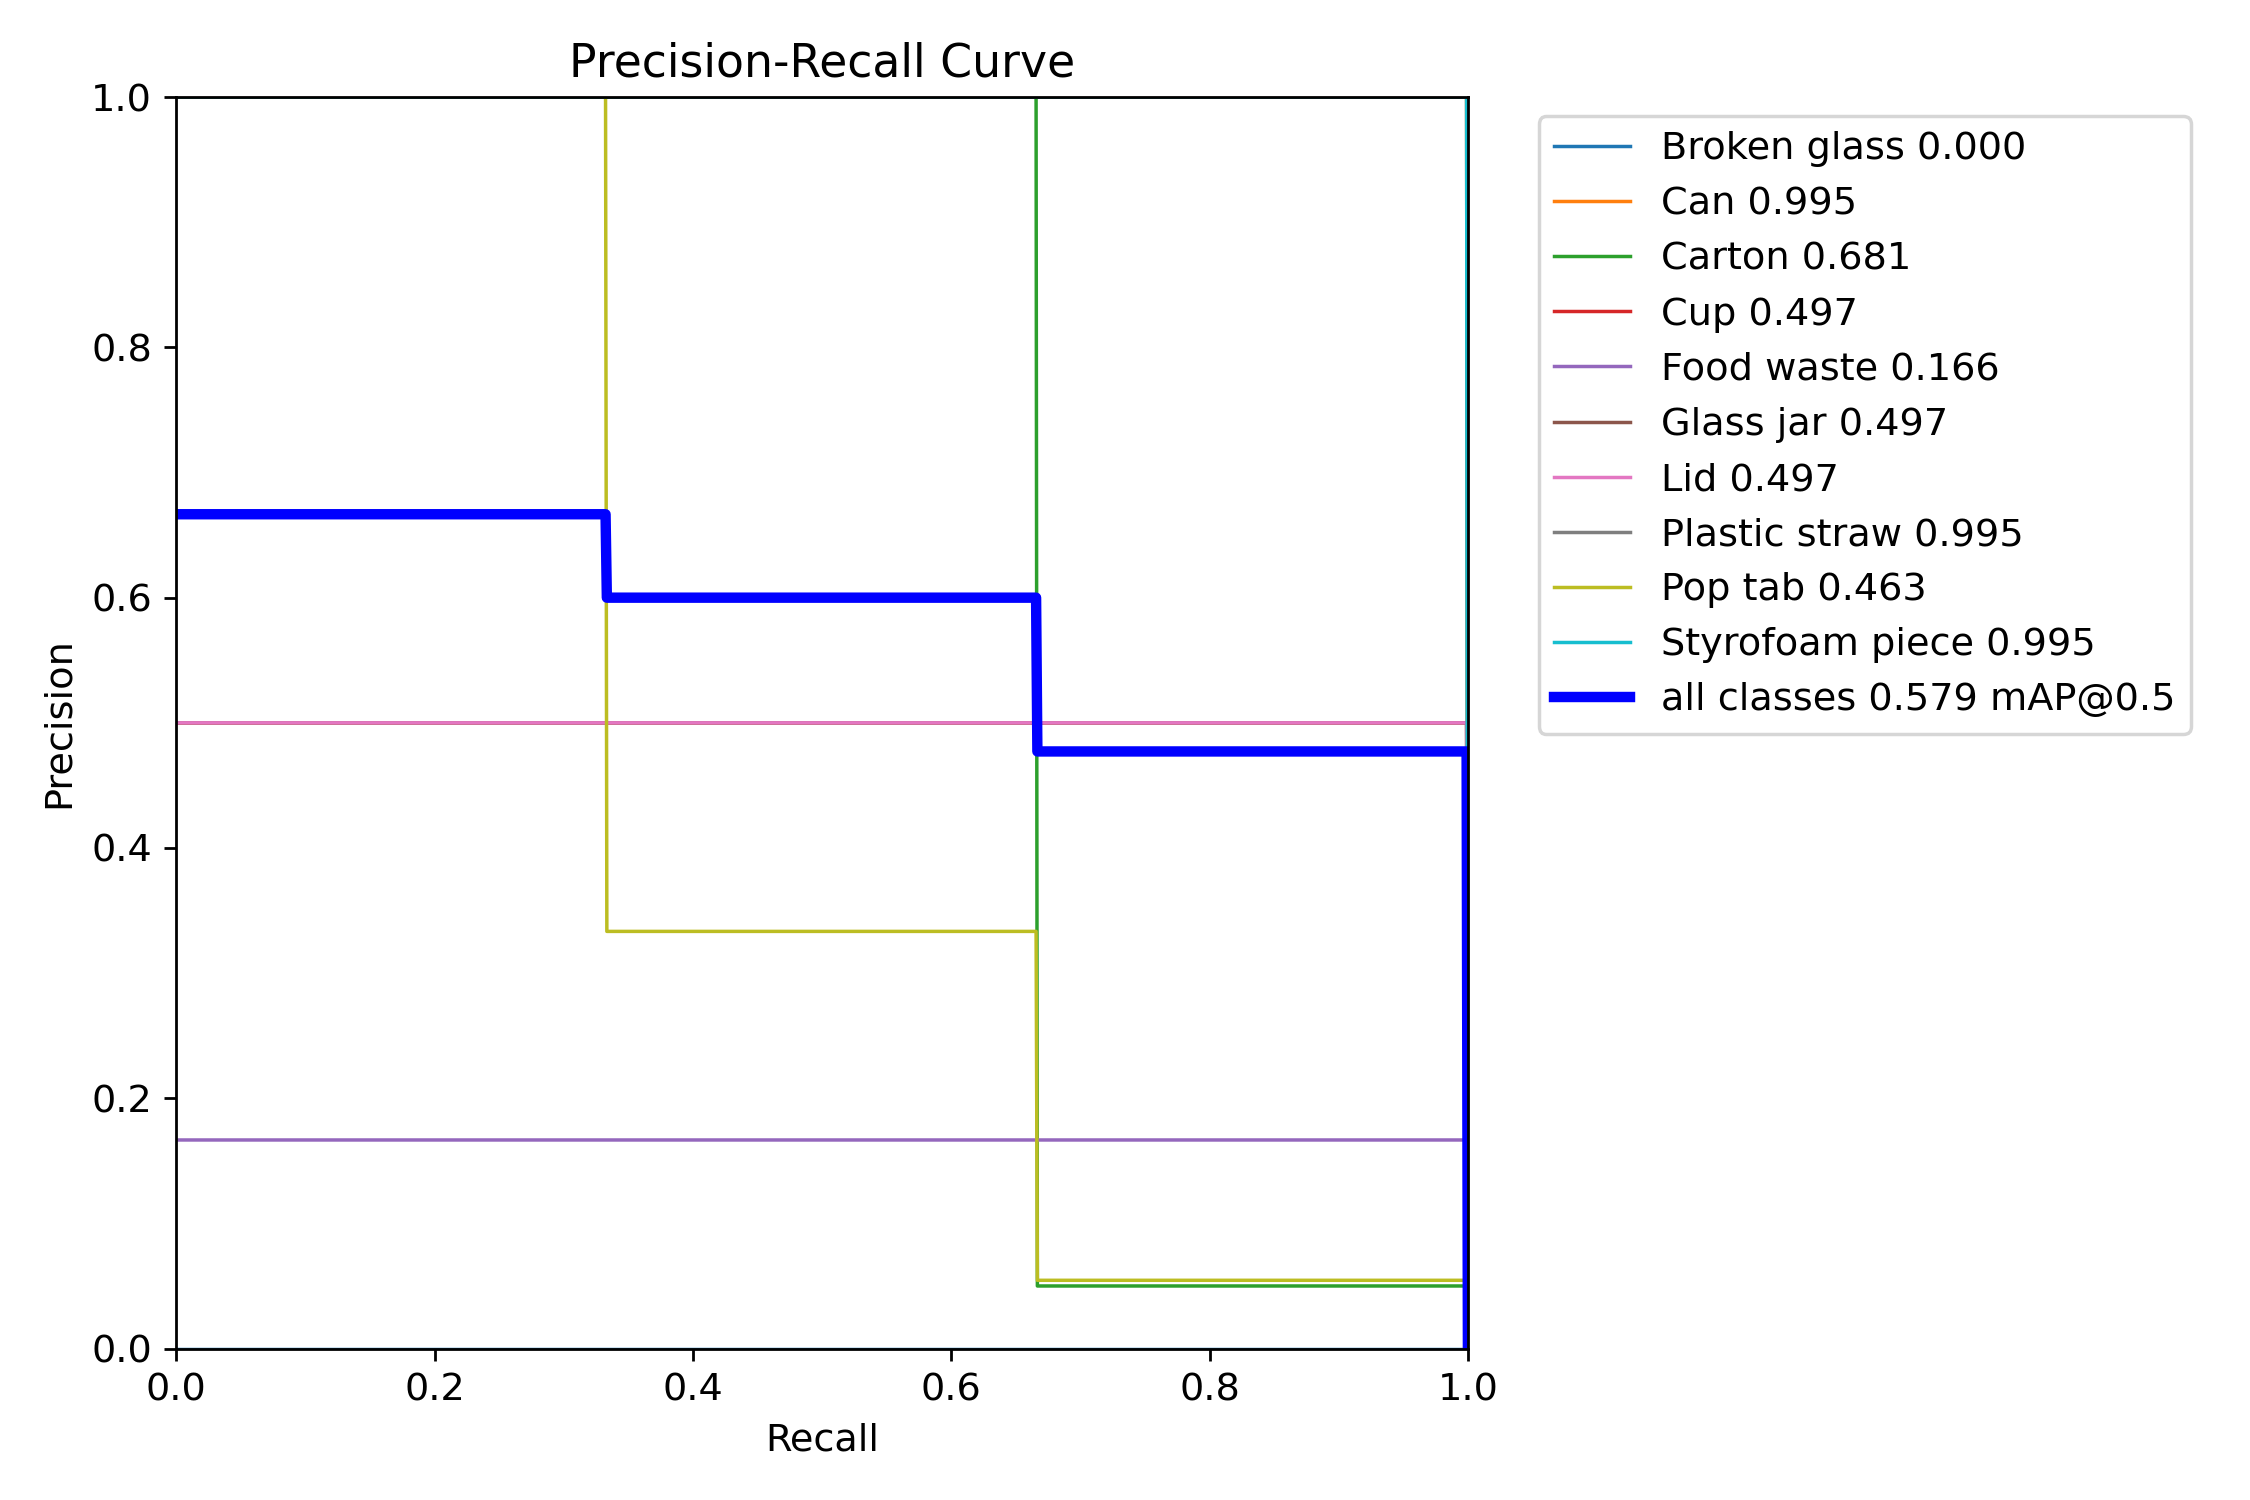

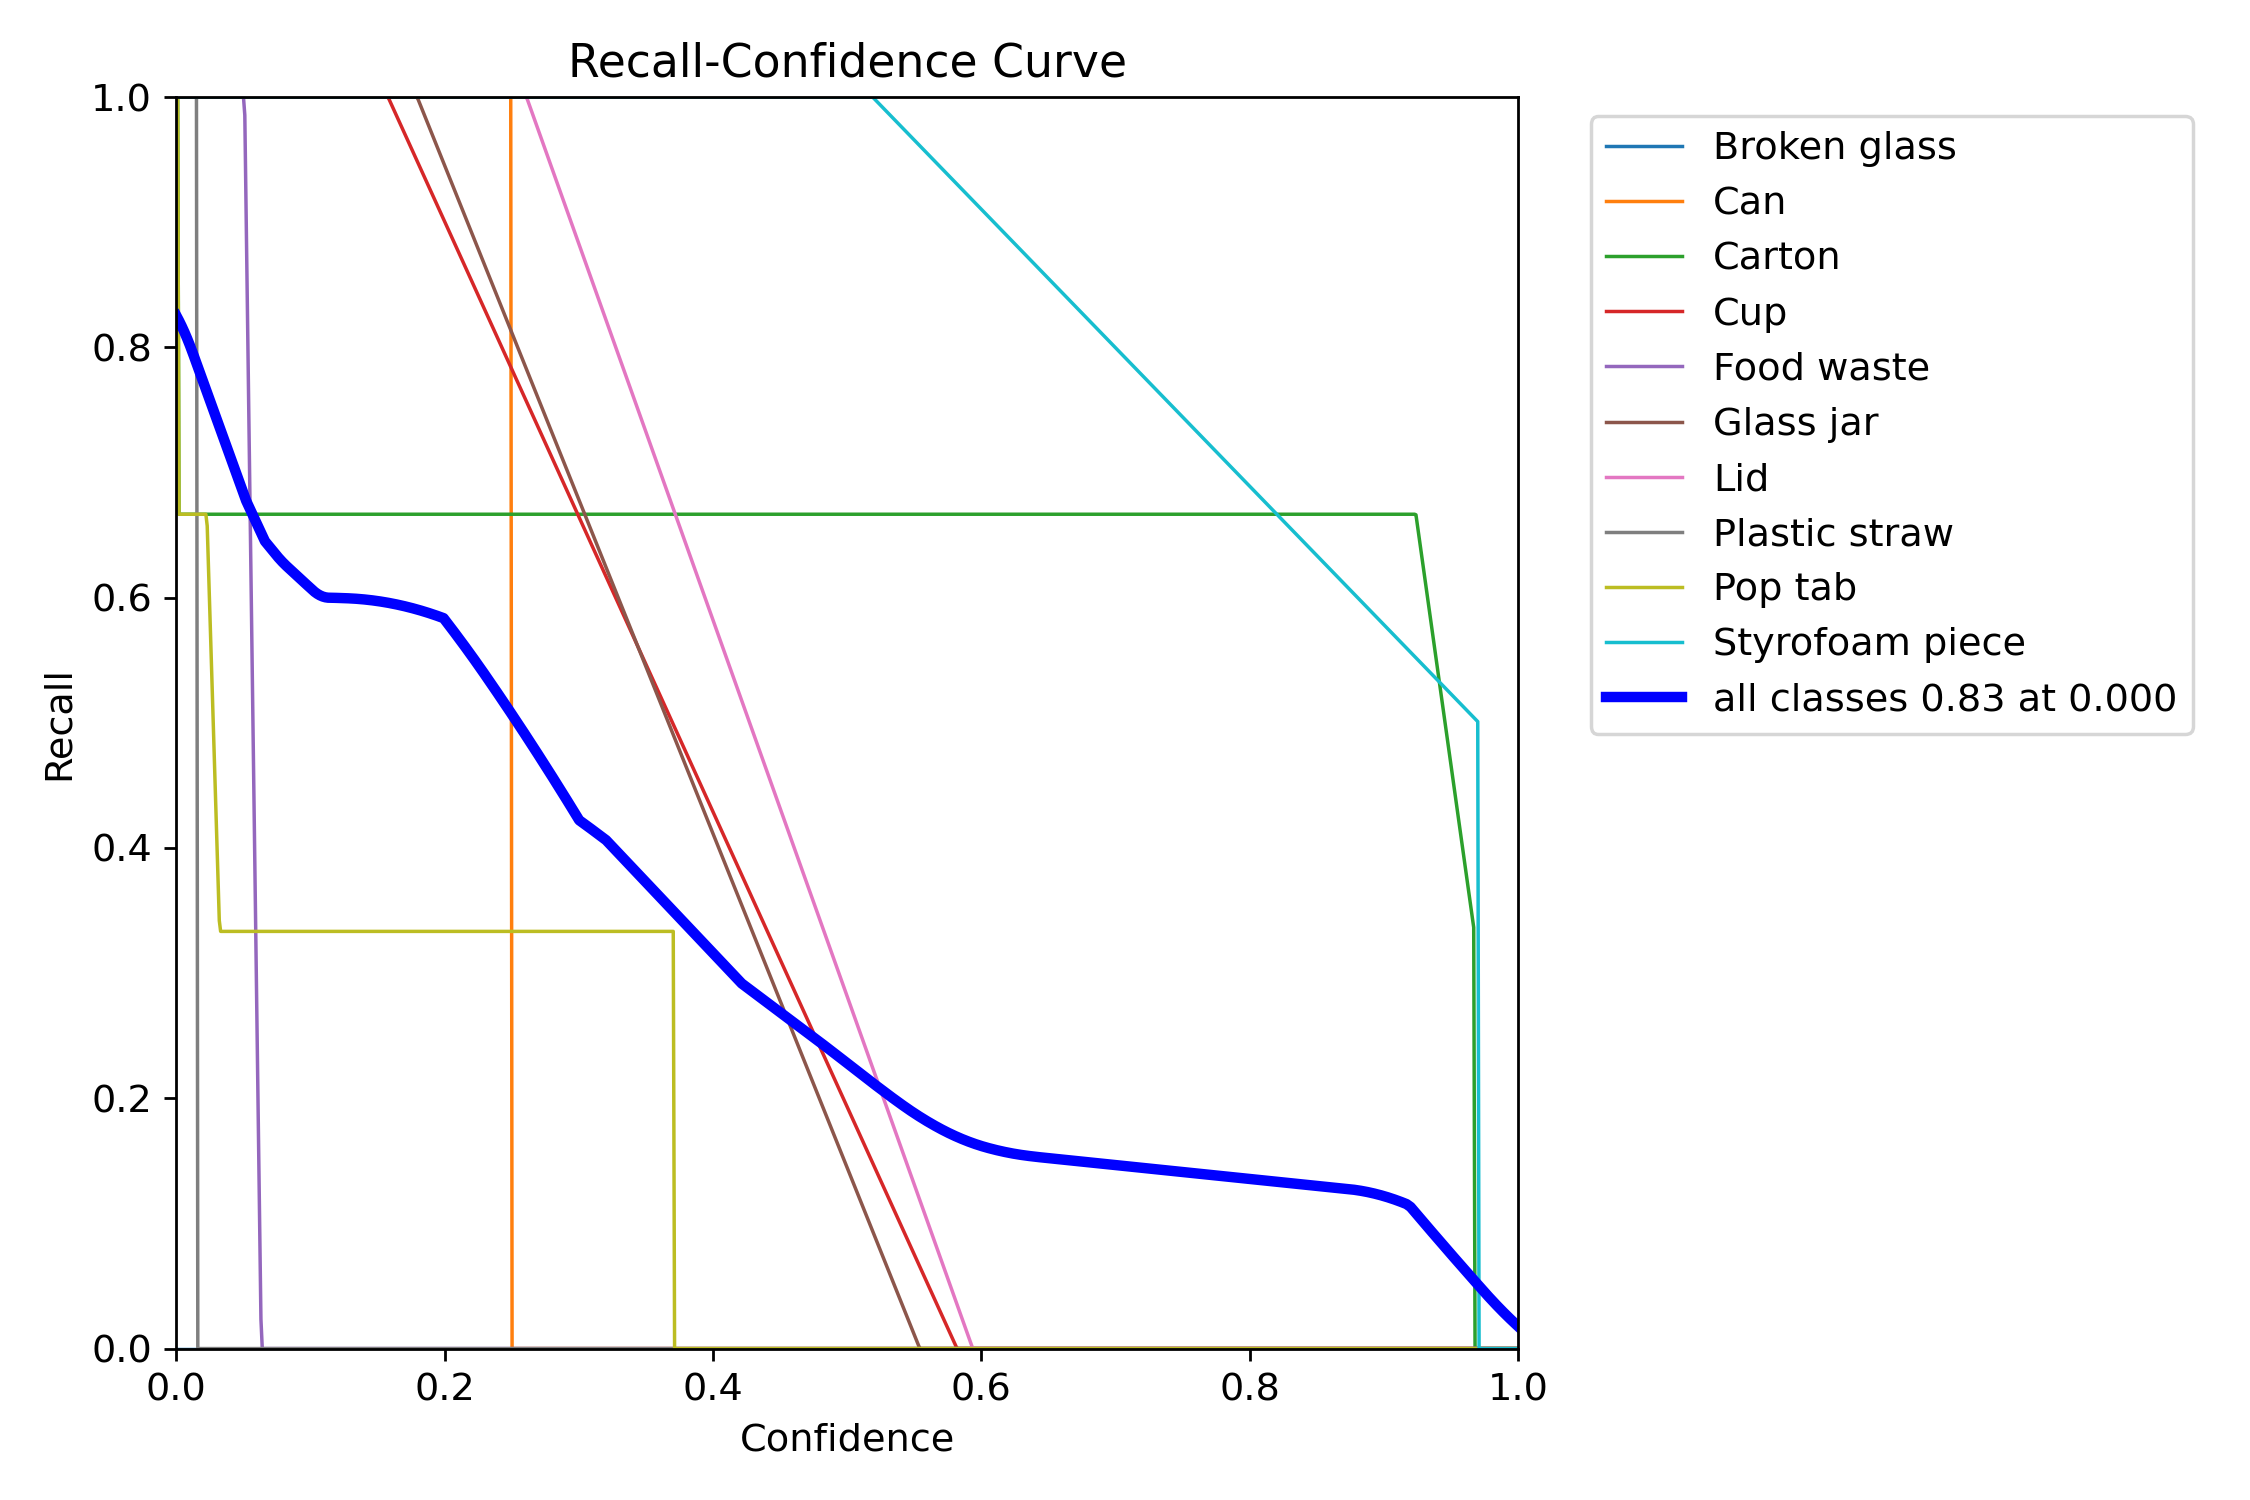

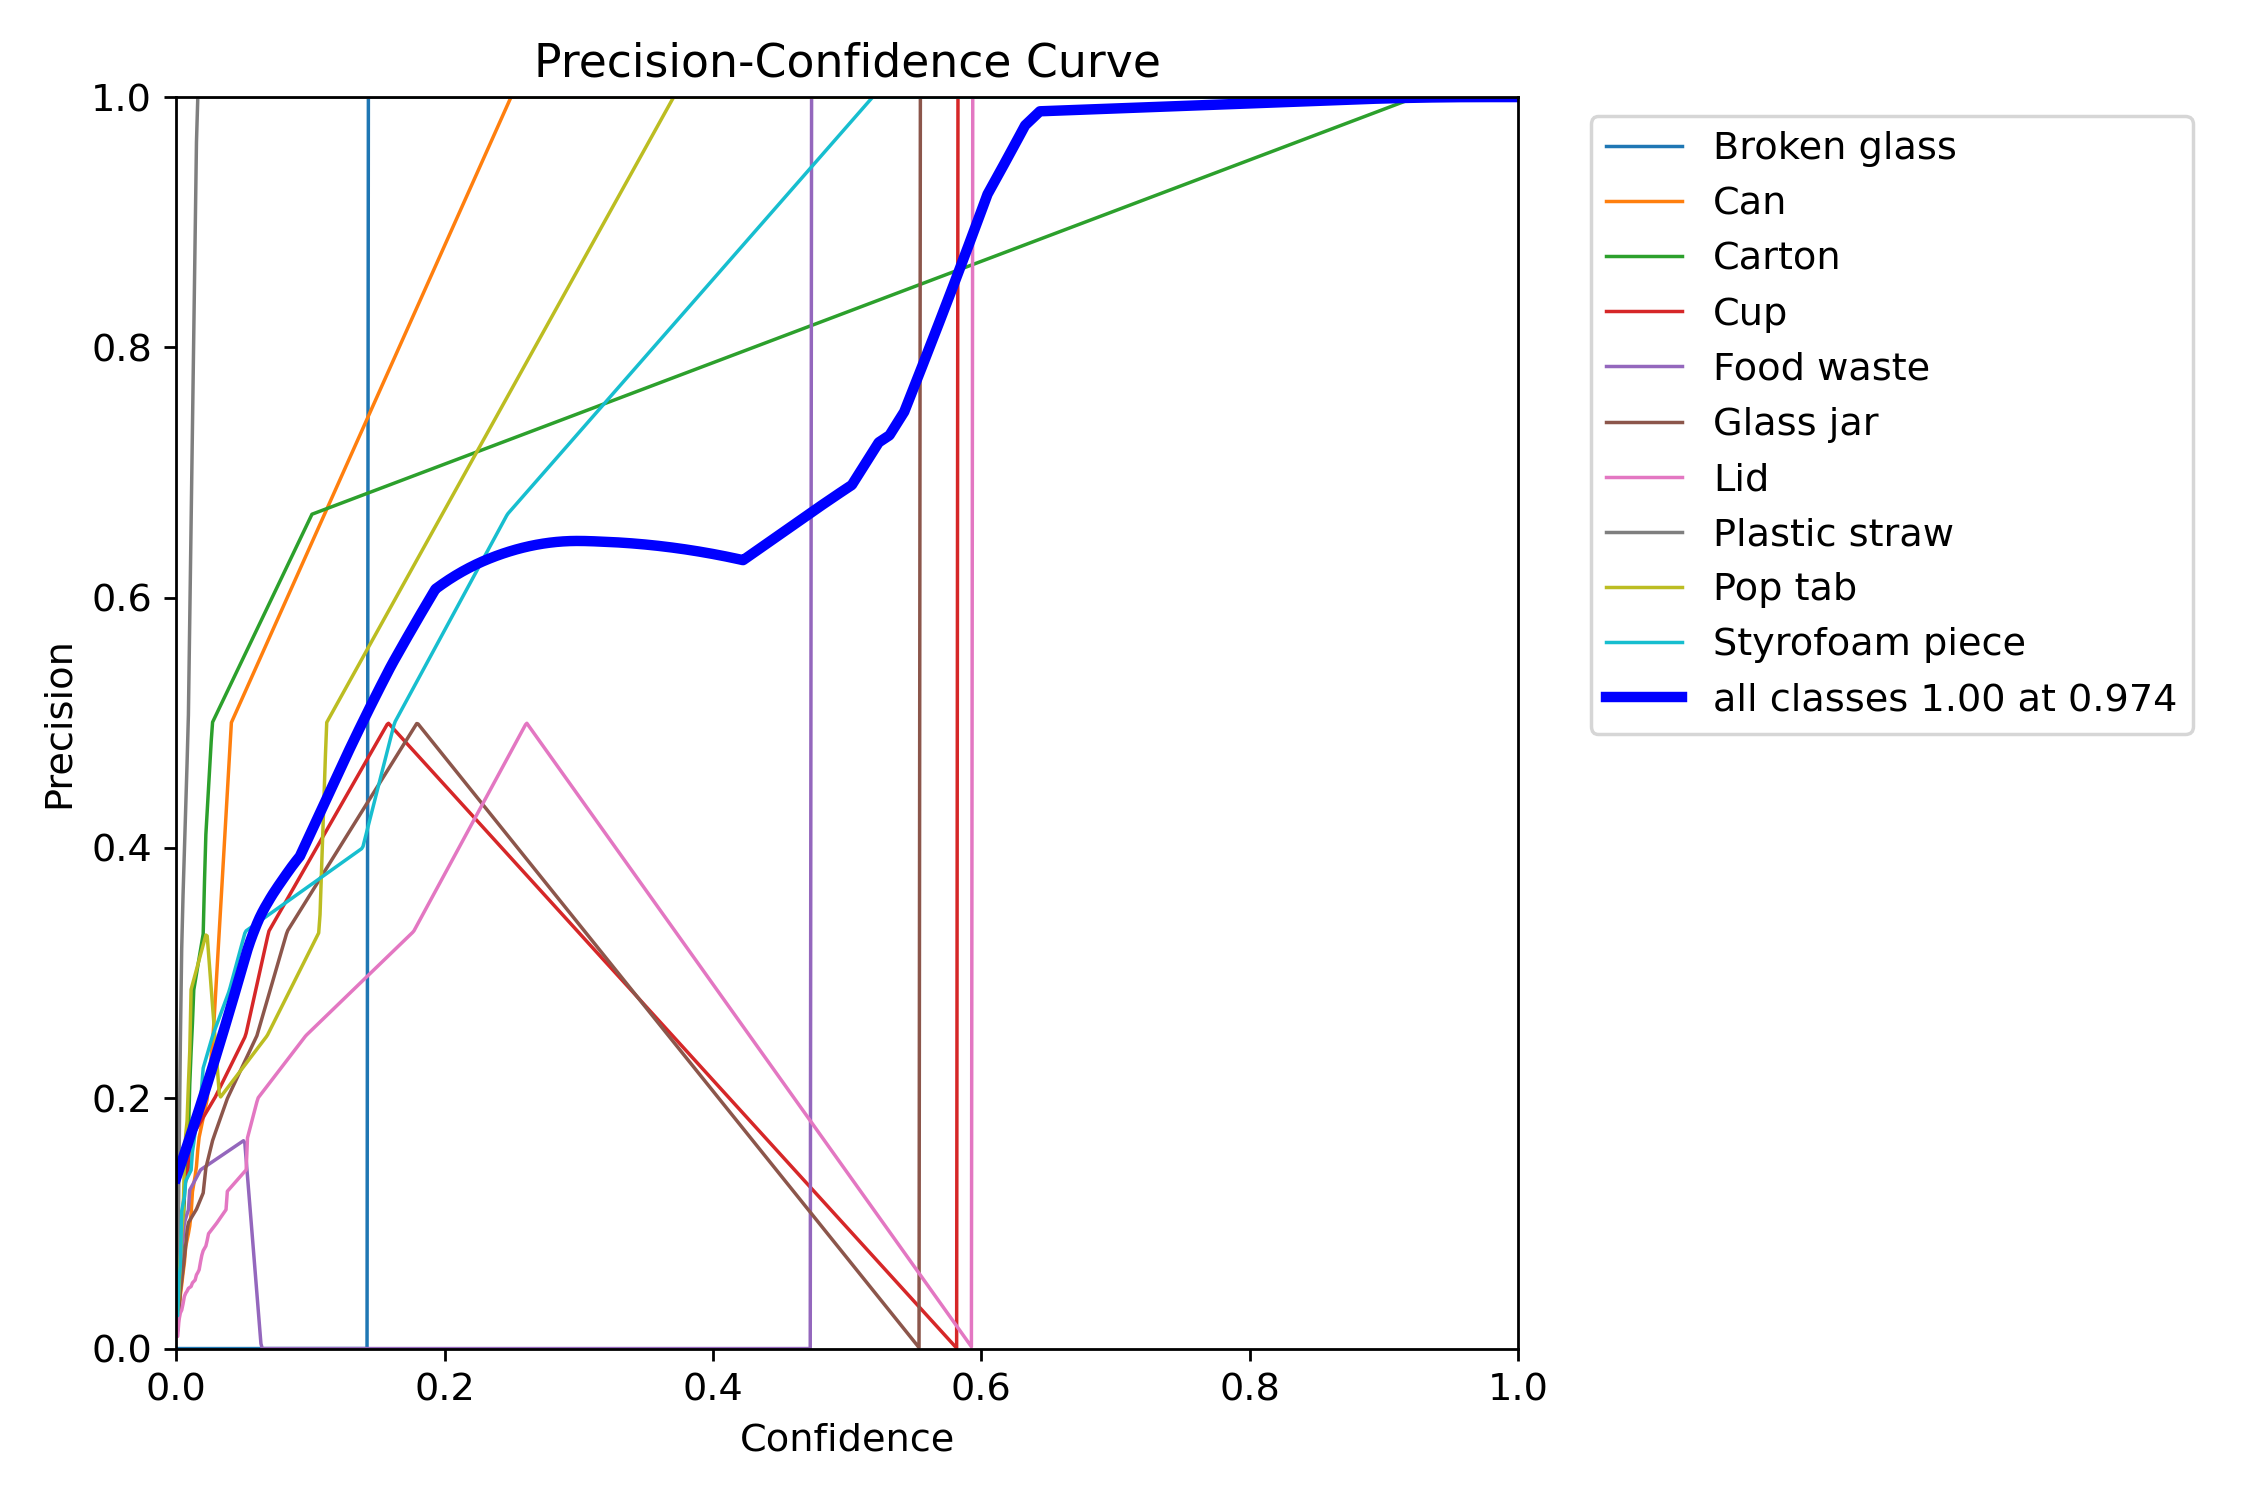

In [31]:
import glob
from IPython.display import Image, display

# Find plots in the validation folder
val_plots = glob.glob('/content/runs/detect/val/*_curve.png')

for plot in val_plots:
    display(Image(filename=plot))


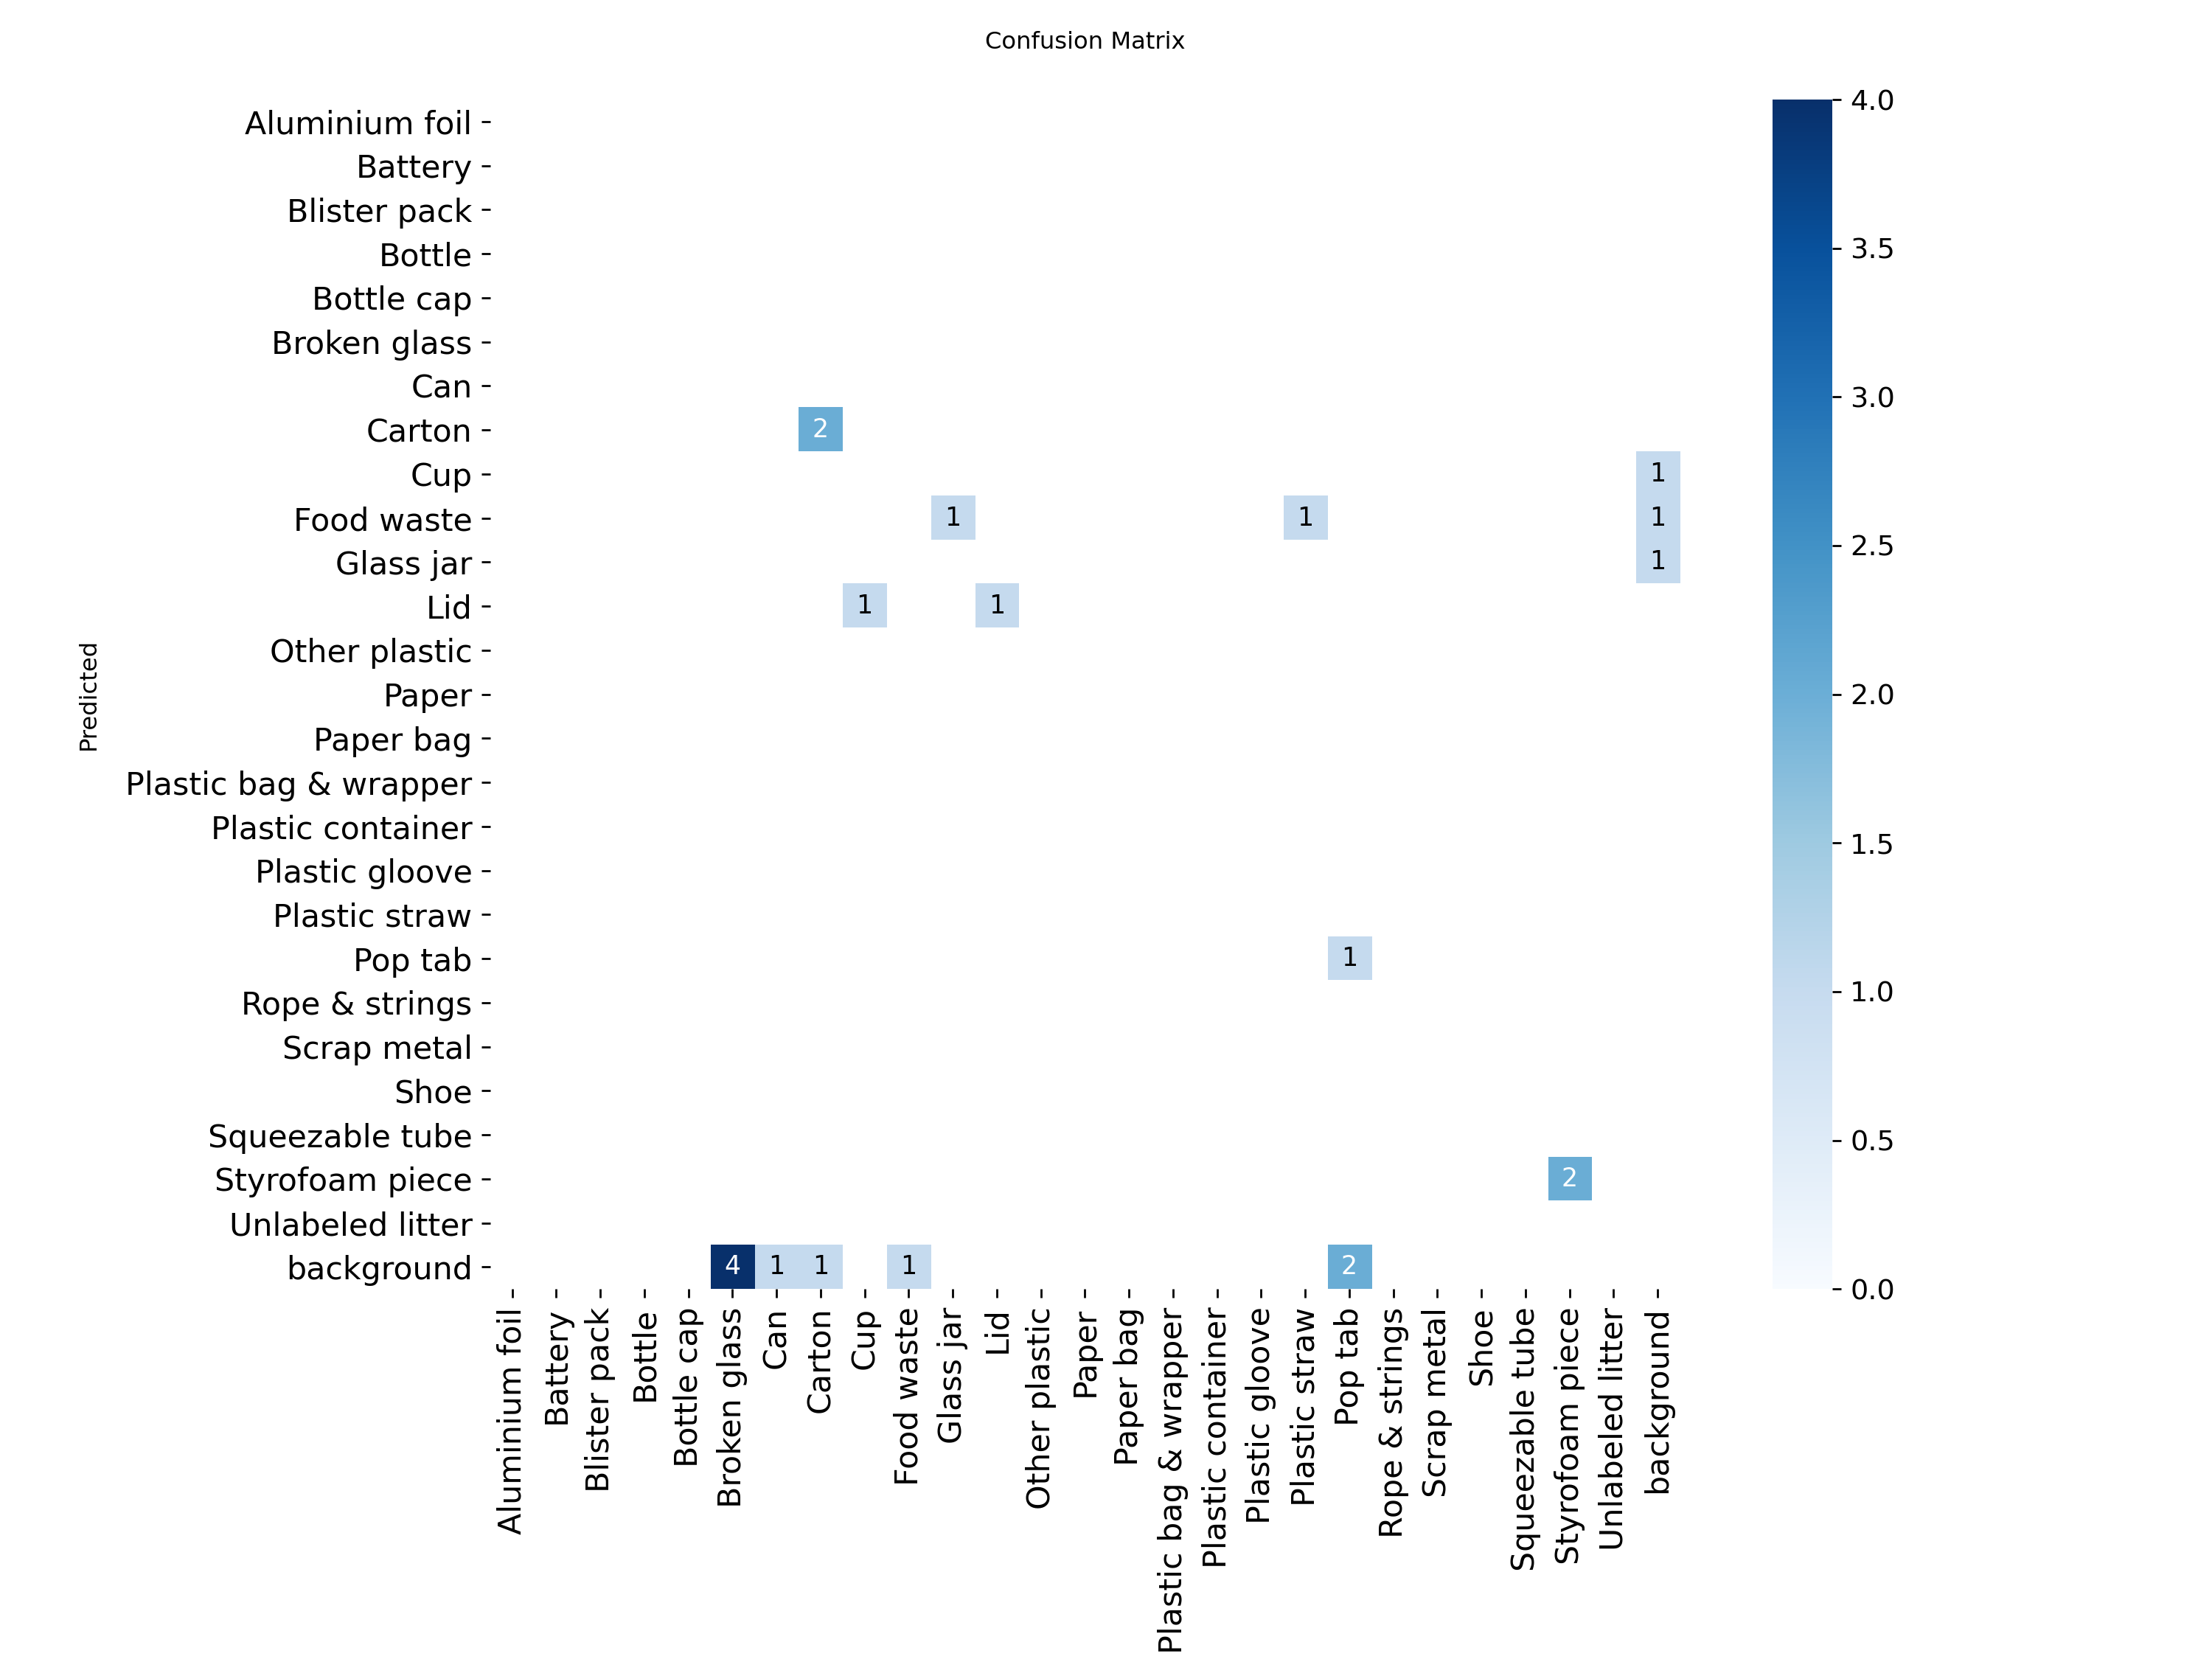

In [32]:
display(Image(filename='/content/runs/detect/val/confusion_matrix.png'))
